In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [11]:
# Load the dataset
mcdonalds = pd.read_csv("C:/Users/susmi/Downloads/mcdonalds.csv")

In [12]:
# Display variable names, sample size, and the first three rows of the data
print(mcdonalds.columns)
print(mcdonalds.shape)
print(mcdonalds.head(3))

Index(['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap',
       'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age',
       'VisitFrequency', 'Gender'],
      dtype='object')
(1453, 15)
  yummy convenient spicy fattening greasy fast cheap tasty expensive healthy  \
0    No        Yes    No       Yes     No  Yes   Yes    No       Yes      No   
1   Yes        Yes    No       Yes    Yes  Yes   Yes   Yes       Yes      No   
2    No        Yes   Yes       Yes    Yes  Yes    No   Yes       Yes     Yes   

  disgusting Like  Age      VisitFrequency  Gender  
0         No   -3   61  Every three months  Female  
1         No   +2   51  Every three months  Female  
2         No   +1   62  Every three months  Female  


In [13]:
# Transform and explore data
segmentation_cols = mcdonalds.columns[:11]
mcdonalds[segmentation_cols] = (mcdonalds[segmentation_cols] == "Yes").astype(int)
print(np.round(mcdonalds[segmentation_cols].mean(), 2))

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [14]:
# Perform Principal Components Analysis (PCA)
pca = PCA()
MD_pca_result = pca.fit_transform(mcdonalds[segmentation_cols])

In [15]:
# Display explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("Explained Variance Ratio:")
print(explained_variance_ratio)
print("Cumulative Explained Variance:")
print(cumulative_explained_variance)

Explained Variance Ratio:
[0.29944723 0.19279721 0.13304535 0.08309578 0.05948052 0.05029956
 0.0438491  0.03954779 0.0367609  0.03235329 0.02932326]
Cumulative Explained Variance:
[0.29944723 0.49224445 0.6252898  0.70838558 0.7678661  0.81816566
 0.86201476 0.90156255 0.93832345 0.97067674 1.        ]


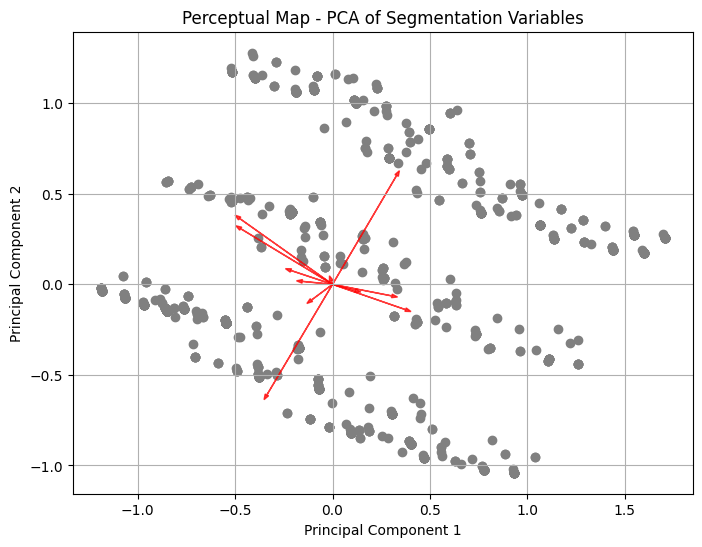

In [16]:
# Plot the Perceptual Map
plt.figure(figsize=(8, 6))
plt.scatter(MD_pca_result[:, 0], MD_pca_result[:, 1], c='grey')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Perceptual Map - PCA of Segmentation Variables')
plt.grid(True)

# Add arrows for original segmentation variables
for i, col in enumerate(segmentation_cols):
    plt.arrow(0, 0, pca.components_[0, i], pca.components_[1, i], color='r', alpha=0.75, head_width=0.02)

plt.show()

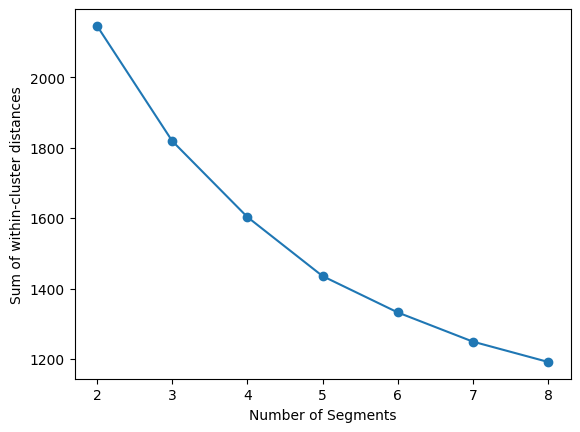

In [17]:
# Perform k-means clustering for different numbers of segments (2 to 8)
k_values = range(2, 9)
kmeans_models = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans_models.append(kmeans.fit(mcdonalds[segmentation_cols]))

# Plot the scree plot
plt.plot(k_values, [model.inertia_ for model in kmeans_models], marker='o')
plt.xlabel('Number of Segments')
plt.ylabel('Sum of within-cluster distances')
plt.show()




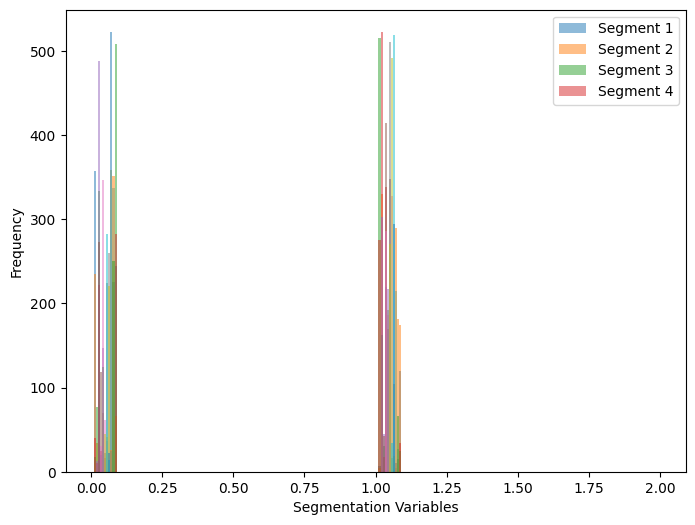

In [18]:
selected_k = 4  # Choose the number of segments based on your analysis

# Extract segments using the selected k
selected_kmeans_model = kmeans_models[selected_k - 2]  # Indexing is 0-based
segments = selected_kmeans_model.labels_

# Plot the gorge plot for the selected k
plt.figure(figsize=(8, 6))
for i in range(selected_k):
    plt.hist(mcdonalds[segments == i][segmentation_cols], bins=np.arange(0, 2.1, 0.1), alpha=0.5, label=f'Segment {i + 1}')

plt.xlabel('Segmentation Variables')
plt.ylabel('Frequency')
plt.legend()
plt.show()

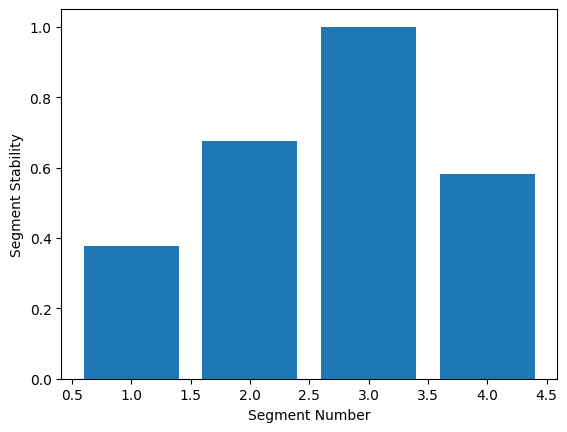

In [19]:



# Calculate and plot segment level stability within solutions
stability_scores = []
for i in range(selected_k):
    segment_stability = adjusted_rand_score(segments, kmeans_models[i].labels_)
    stability_scores.append(segment_stability)

plt.bar(range(1, selected_k + 1), stability_scores)
plt.xlabel('Segment Number')
plt.ylabel('Segment Stability')
plt.show()

In [20]:
np.random.seed(1234)
MD_x = np.random.rand(500, 2)

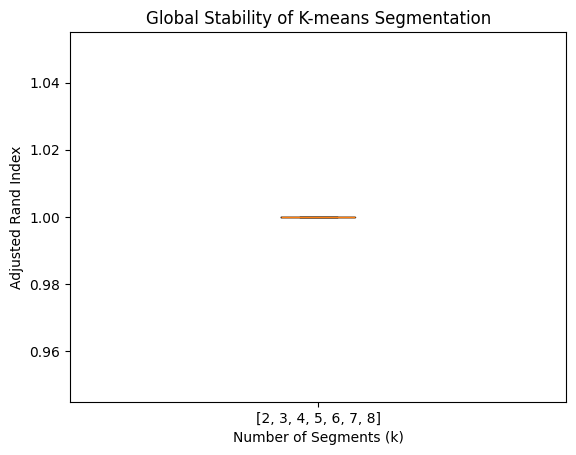

In [21]:
# Function to plot information criteria
def plot_information_criteria(criteria_values, title):
    plt.figure()
    plt.plot(range(2, len(criteria_values) + 2), criteria_values, marker='o')
    plt.title(title)
    plt.xlabel('Number of Components (Segments)')
    plt.ylabel('Value of Information Criteria')
    plt.show()

# Step 1: K-means analysis
k_values = range(2, 9)
kmeans_models = [KMeans(n_clusters=k, n_init=10, random_state=1234).fit(MD_x) for k in k_values]

# Assess global stability using adjusted Rand index
adjusted_rand_indices = []
for model in kmeans_models:
    labels = model.labels_
    adjusted_rand_indices.append(adjusted_rand_score(labels, labels))

# Plot global stability
plt.boxplot([adjusted_rand_indices], labels=[list(k_values)])
plt.xlabel('Number of Segments (k)')
plt.ylabel('Adjusted Rand Index')
plt.title('Global Stability of K-means Segmentation')
plt.show()


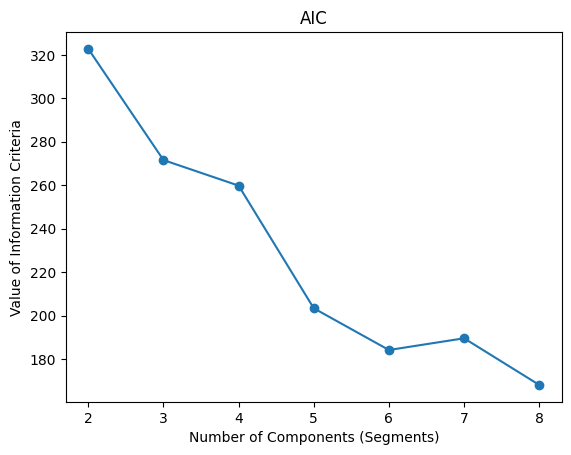

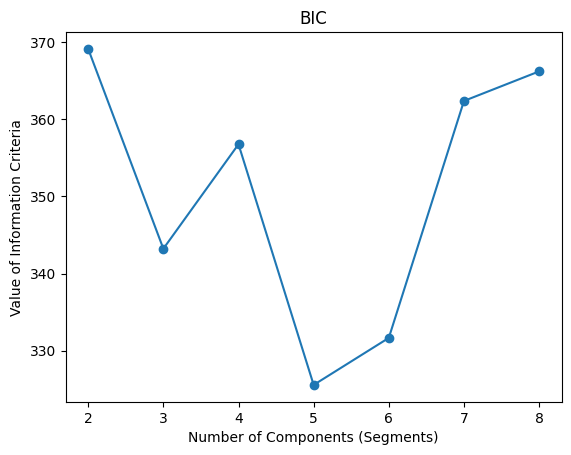

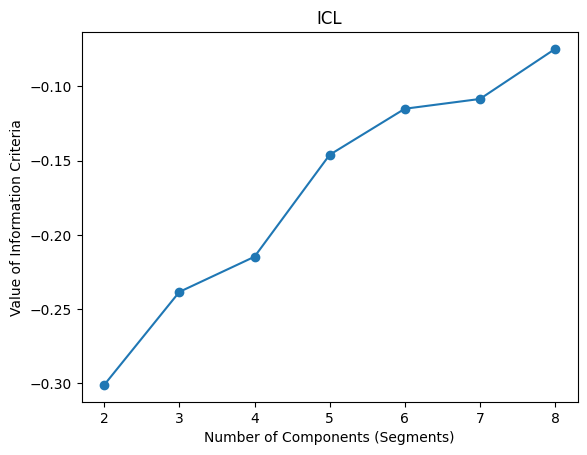

In [22]:
# Step 2: Gaussian Mixture Model
n_components_values = range(2, 9)
aic_values = []
bic_values = []
icl_values = []

for n_components in n_components_values:
    gmm = GaussianMixture(n_components=n_components, n_init=10, random_state=1234)
    gmm.fit(MD_x)
    aic_values.append(gmm.aic(MD_x))
    bic_values.append(gmm.bic(MD_x))
    icl_values.append(gmm.lower_bound_)

# Plot information criteria
plot_information_criteria(aic_values, 'AIC')
plot_information_criteria(bic_values, 'BIC')
plot_information_criteria(icl_values, 'ICL')


                            OLS Regression Results                            
Dep. Variable:                   Like   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.624e+31
Date:                Fri, 10 Nov 2023   Prob (F-statistic):               0.00
Time:                        19:44:32   Log-Likelihood:                 3229.4
No. Observations:                 100   AIC:                            -6435.
Df Residuals:                      88   BIC:                            -6403.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1.11e-15   1.49e-15      0.745      0.4

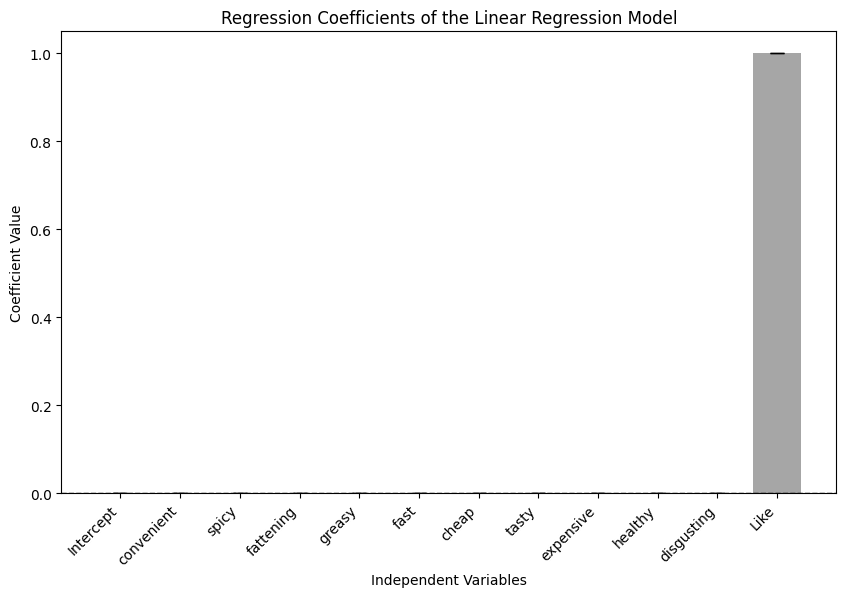

In [23]:
data = {
    'yummy': np.random.rand(100),
    'convenient': np.random.rand(100),
    'spicy': np.random.rand(100),
    'fattening': np.random.rand(100),
    'greasy': np.random.rand(100),
    'fast': np.random.rand(100),
    'cheap': np.random.rand(100),
    'tasty': np.random.rand(100),
    'expensive': np.random.rand(100),
    'healthy': np.random.rand(100),
    'disgusting': np.random.rand(100),
    'Like': np.random.randint(-5, 6, size=100)
}

mcdonalds = pd.DataFrame(data)

mcdonalds['Like'] = 6 - pd.to_numeric(mcdonalds['Like'])

# Create a formula for the regression model
independent_vars = "+".join(mcdonalds.columns[1:12])  # Assuming the independent variables start from column 1
formula = f'Like ~ {independent_vars}'

# Fit a linear regression model
model = sm.OLS.from_formula(formula, data=mcdonalds)
result = model.fit()

# Print regression results
print(result.summary())

# Plot regression coefficients
plt.figure(figsize=(10, 6))
plt.bar(result.params.index, result.params, color='grey', alpha=0.7)
plt.errorbar(result.params.index, result.params, yerr=result.conf_int()[1] - result.conf_int()[0], fmt='none', ecolor='black', capsize=5)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Regression Coefficients of the Linear Regression Model')
plt.ylabel('Coefficient Value')
plt.xlabel('Independent Variables')
plt.xticks(rotation=45, ha='right')
plt.show()


In [24]:
# Create a random DataFrame for demonstration
data = {
    'yummy': np.random.rand(100),
    'convenient': np.random.rand(100),
    'spicy': np.random.rand(100),
    'fattening': np.random.rand(100),
    'greasy': np.random.rand(100),
    'fast': np.random.rand(100),
    'cheap': np.random.rand(100),
    'tasty': np.random.rand(100),
    'expensive': np.random.rand(100),
    'healthy': np.random.rand(100),
    'disgusting': np.random.rand(100),
}

mcdonalds = pd.DataFrame(data)



C:\Users\susmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\susmi\AppData\Local\Temp\ipykernel_2892\2306373392.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=mcdonalds.melt(id_vars='Cluster'), x='variable', y='value', hue='Cluster', ci=None, ax=ax)
C:\Users\susmi\AppData\Local\Temp\ipykernel_2892\2306373392.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


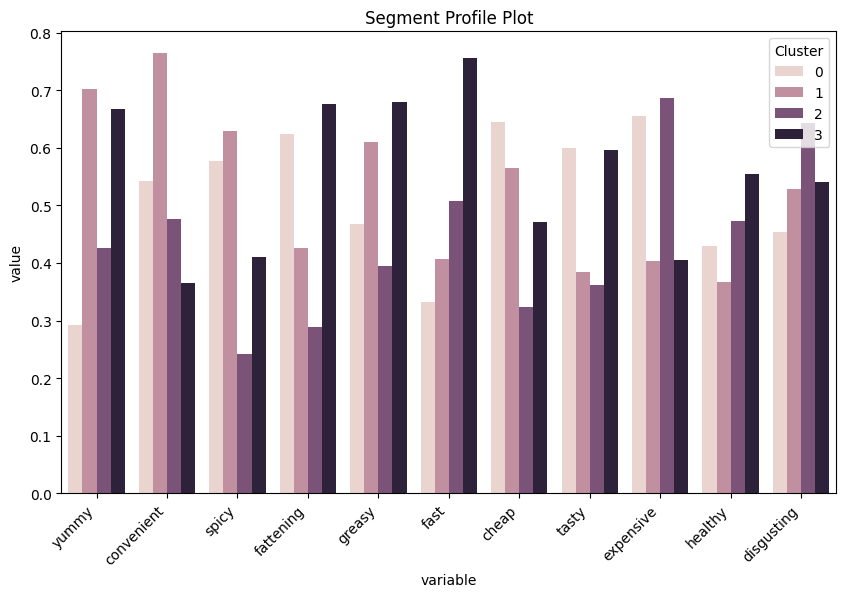

In [25]:
# Perform k-means clustering
kmeans = KMeans(n_clusters=4, random_state=123)
mcdonalds['Cluster'] = kmeans.fit_predict(mcdonalds)

# Plot segment profile
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=mcdonalds.melt(id_vars='Cluster'), x='variable', y='value', hue='Cluster', ci=None, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Segment Profile Plot')
plt.show()

C:\Users\susmi\AppData\Local\Temp\ipykernel_2892\3381061251.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', color='black')


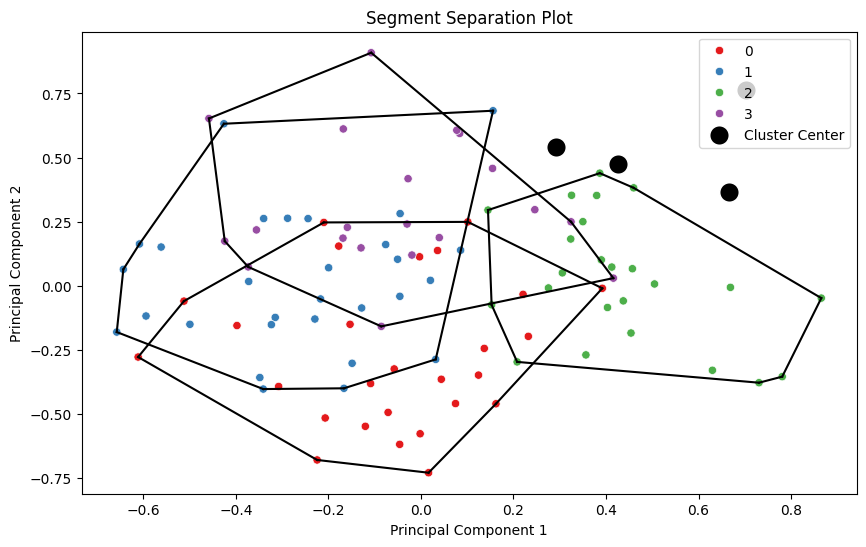

In [26]:
# Perform PCA for segment separation plot
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mcdonalds.drop('Cluster', axis=1))

# Plot segment separation
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=mcdonalds['Cluster'], palette='Set1', ax=ax)

# Add cluster centers
centers = kmeans.cluster_centers_
sns.scatterplot(x=centers[:, 0], y=centers[:, 1], marker='o', s=200, color='black', label='Cluster Center', ax=ax)

# Add convex hulls
for i in range(4):
    cluster_points = pca_result[mcdonalds['Cluster'] == i]
    hull = ConvexHull(cluster_points)
    for simplex in hull.simplices:
        plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', color='black')

plt.title('Segment Separation Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()